In [12]:
import pandas as pd
import numpy as np
import datetime as dt
import time

from IPython.core.pylabtools import figsize
from statsmodels.graphics.agreement import mean_diff_plot

In [13]:
# 从shibor官网https://www.shibor.org/shibor/index.html下的数据，但一次只支持下一年的，而且数据都是str，注意转换一下。
shibor = pd.read_excel('../Shibor.xlsx')
shibor.rename(columns={'日期':'date'}, inplace=True)
shibor.set_index('date', inplace=True, drop=True)
shibor = shibor.iloc[:-2,:]
shibor = shibor.iloc[::-1,:]
shibor = shibor.astype(float)
shibor.head()

/Users/wangyilin/PycharmProjects/vix/.venv/lib/python3.11/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,O/N,1W,2W,1M,3M,6M,9M,1Y
date,,,,,,,,
2024-01-02,1.586,1.786,2.078,2.398,2.450,2.498,2.515,2.532
2024-01-03,1.604,1.805,1.877,2.354,2.423,2.479,2.497,2.509
2024-01-04,1.589,1.783,1.882,2.329,2.399,2.456,2.480,2.496
2024-01-05,1.588,1.770,1.978,2.320,2.396,2.448,2.472,2.491
2024-01-08,1.585,1.772,1.999,2.312,2.396,2.444,2.460,2.485


In [14]:
# 三次样条插值得到需要的无风险收益率
from scipy.interpolate import interp1d
def interpld_shibor(shibor_df):
    def _interpld_fun(r):
        y_vals = r.values / 100

        daily_range = np.arange(1, 365)
        periods = [1, 7, 14, 30, 90, 180, 270, 365]

        f = interp1d(periods, y_vals, kind='cubic')
        t_ser = pd.Series(data=f(daily_range), index=daily_range)

        return t_ser
    shibor_df = shibor_df.apply(lambda x: _interpld_fun(x), axis=1)
    return shibor_df
shibor_continuous = interpld_shibor(shibor)
shibor_continuous.head()

,1,2,3,4,5,6,7,8,9,10,...,355,356,357,358,359,360,361,362,363,364
date,,,,,,,,,,,,,,,,,,,,,
2024-01-02,0.01586,0.016098,0.016383,0.016708,0.017067,0.017453,0.01786,0.018282,0.018713,0.019147,...,0.025220,0.025228,0.025237,0.025247,0.025256,0.025266,0.025276,0.025287,0.025298,0.025309
2024-01-03,0.01604,0.016574,0.017013,0.017370,0.017654,0.017877,0.01805,0.018183,0.018288,0.018376,...,0.024829,0.024851,0.024874,0.024898,0.024923,0.024948,0.024975,0.025002,0.025031,0.025060
2024-01-04,0.01589,0.016367,0.016771,0.017111,0.017396,0.017632,0.01783,0.017997,0.018141,0.018272,...,0.024727,0.024747,0.024768,0.024789,0.024811,0.024834,0.024858,0.024882,0.024907,0.024933
2024-01-05,0.01588,0.016175,0.016475,0.016778,0.017084,0.017392,0.01770,0.018008,0.018313,0.018616,...,0.024779,0.024790,0.024802,0.024814,0.024826,0.024839,0.024853,0.024866,0.024880,0.024895
2024-01-08,0.01585,0.016131,0.016428,0.016738,0.017058,0.017386,0.01772,0.018056,0.018393,0.018727,...,0.024724,0.024735,0.024747,0.024758,0.024770,0.024783,0.024796,0.024809,0.024822,0.024836


In [15]:
# 以2024年4月1日为例

In [16]:
# Load data
option_data = pd.read_pickle('../option_data.pkl')
option_50 = option_data[option_data['symbol_id']==50]
option_300 = option_data[option_data['symbol_id']==300]
option_1000 = option_data[option_data['symbol_id']==1000]

In [17]:
# 当日无风险收益率
rf = shibor_continuous.loc['2024-04-01']

In [18]:
# 处理期权数据
# options = option_50[['delivery_date','delivery_price','is_call','time','price','volume']].copy()
options = option_300[['delivery_date','delivery_price','is_call','time','price','volume']].copy()
# options = option_500[['delivery_date','delivery_price','is_call','time','price','volume']].copy()
# 计算到期时间（每个月第三个周五是行权日）
options['delivery_date']=options['delivery_date']+200000
def get_third_friday(yyyymm):
    year = int(str(int(yyyymm))[:4])
    month = int(str(int(yyyymm))[4:])
    first_day_of_month = dt.datetime(year, month, 1)
    first_weekday = first_day_of_month.weekday()
    days_to_third_friday = (4 - first_weekday + 7 * 2) % 7
    third_friday = first_day_of_month + dt.timedelta(days=days_to_third_friday + 14)
    return third_friday
options['days'] = (options['delivery_date'].apply(get_third_friday)-pd.to_datetime('20240401')).dt.days
options.drop(columns='delivery_date',inplace=True)
options['time'] = pd.to_datetime(options['time'])
# 我们的数据频率是500ms，但这里按分钟截断
options['time'] = options['time'].dt.floor('min')

$$\sigma^{2}=\frac{2}{T}\sum_{i=1}^{n}\frac{\Delta K_{i}}{K_{i}^{2}}e^{rT}M_{i}-\frac{1}{T}\left(\frac{F}{K_{0}}-1\right)^{2},$$

In [19]:
def cal_VIX(options, rf):
    if len(options)<1000:
        return 0
    # 选取近月和次近月option
    times = options['time'].unique()[0]
    near_days, next_days = sorted(options['days'].unique()[options['days'].unique() > 5])[:2]
    # 分别计算weight：
    near_minite = near_days * 24 * 60 - (times.minute + times.hour * 60)
    next_minite = next_days * 24 * 60 - (times.minute + times.hour * 60)
    near_weight = (next_minite - 30 * 24 * 60) / (next_minite - near_minite)
    next_weight = (30 * 24 * 60 - near_minite) / (next_minite - near_minite)
    near_options = options[options['days'] == near_days].copy()
    next_options = options[options['days'] == next_days].copy()
    near_options.drop(columns=['days', 'time'], inplace=True)
    next_options.drop(columns=['days', 'time'], inplace=True)

    # 某分钟的五档快照信息若少于500个，可以认为这个节点算出的波动率不准（流动性差），直接使用上一时刻的即可。
    if len(near_options)<500 or len(next_options)<500:
        return 0
    else:
        # 分别计算sigma
        sigma_near = _cal_sigma(near_options,rf, times, near_days)
        sigma_next = _cal_sigma(next_options,rf, times, next_days)
        # 计算VIX
        V = (near_days * sigma_near * near_weight + next_days * sigma_next * next_weight)/30
        VIX = 100 * np.sqrt(V)
        return VIX

def _weighted_average(group):
    d = {'weighted_price': (group['price'] * group['volume']).sum() / group['volume'].sum()}
    return pd.Series(d)

def _cal_sigma(options,rf, times, days):
    # 交易量为0的option不参与价格计算
    options = options[options['volume']!=0]
    # 计算加权平均价格
    call_put_df = options.groupby(['delivery_price', 'is_call']).apply(_weighted_average,
                                                                        include_groups=False).reset_index()
    call_options = call_put_df[call_put_df['is_call'] == 1].set_index('delivery_price').drop(columns='is_call')
    put_options = call_put_df[call_put_df['is_call'] == 0].set_index('delivery_price').drop(columns='is_call')
    call_put_df = pd.concat([call_options, put_options], axis=1, keys=['call', 'put'])
    call_put_df.columns = call_put_df.columns.droplevel(1)
    call_put_df.sort_index(inplace=True)
    # 寻找平值期权/虚值期权
    K = call_put_df['call'].index[abs(call_put_df['call'] - call_put_df['put']).argmin()]
    P = call_put_df.index <= K
    C = call_put_df.index >= K
    puts, calls = call_put_df[P].drop(columns='call'), call_put_df[C].drop(columns='put')
    # 由PCP得future price
    R = rf.loc[days]
    T = days / 365
    future_price = K + np.exp(R * T) * (calls.loc[K, 'call'] - puts.loc[K, 'put'])
    # 寻找K0:
    K0 = call_put_df.index[call_put_df.index <= future_price][-1]

    # 计算单项波动率
    # 计算delta K
    P0 = call_put_df.index <= K0
    C0 = call_put_df.index >= K0
    # TODO: 或许需要舍弃bid连续为0的数据
    puts0, calls0 = call_put_df[P0].drop(columns='call'), call_put_df[C0].drop(columns='put')
    puts0 = puts0.sort_index(ascending=False)
    calls0 = calls0.sort_index(ascending=True)
    delta_K = []
    for i in range(len(puts0)):
        if i == 0:
            delta_K.append(K0 - puts0.index[i + 1])
        elif i == len(puts0) - 1:
            delta_K.append(puts0.index[i - 1] - puts0.index[i])
        else:
            delta_K.append((puts0.index[i - 1] - puts0.index[i + 1]) / 2)
    puts0['delta_K'] = delta_K
    delta_K = []
    for i in range(len(calls0)):
        if i == 0:
            delta_K.append(calls0.index[i + 1] - K0)
        elif i == len(calls0) - 1:
            delta_K.append(calls0.index[i] - calls0.index[i - 1])
        else:
            delta_K.append((calls0.index[i + 1] - calls0.index[i - 1]) / 2)
    calls0['delta_K'] = delta_K

    # 计算M：
    puts0['M'] = puts0['put']
    puts0.loc[K0, 'M'] = (puts0.loc[K0, 'put'] + calls0.loc[K0, 'call']) / 2
    calls0['M'] = calls0['call']
    calls0 = calls0.iloc[1:]
    options_result = pd.concat([puts0, calls0]).sort_index().dropna(subset=['M'])
    sigma = (2 / T * (options_result['delta_K'] / options_result.index ** 2 * np.exp(R * T) * options_result[
        'M']).sum() - 1 / T * (future_price / K0 - 1) ** 2) ** 0.5
    return sigma


In [20]:
VIX_today = options.groupby('time', group_keys=True).apply(cal_VIX, rf, include_groups=True)

/var/folders/jb/989n_4jn3s1_gfmjf_7mp1ym0000gn/T/ipykernel_61392/2424611830.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  VIX_today = options.groupby('time', group_keys=True).apply(cal_VIX, rf, include_groups=True)


In [21]:
VIX_today = pd.DataFrame(VIX_today)
VIX_today = VIX_today.mask(VIX_today==0).ffill().iloc[1:]
VIX_today.columns = ['VIX']

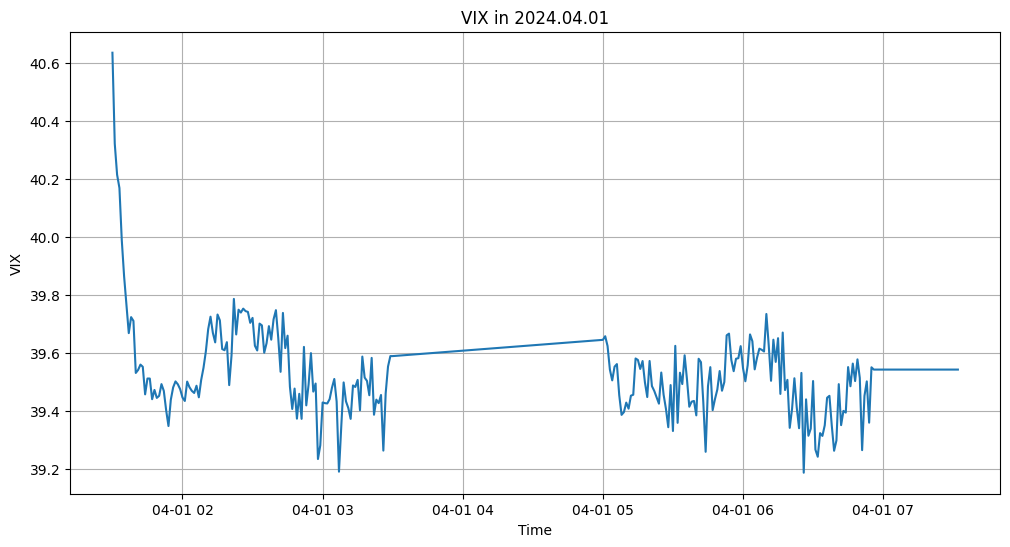

In [22]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(VIX_today.index, VIX_today['VIX'])
plt.title('300 VIX in 2024.04.01')
plt.xlabel('Time')
plt.ylabel('VIX')
plt.grid(True)
plt.show()